## volumetric rate model

The total (integrated) Iax rate should be 20% of the SN Ia rate at z = 0. The rate should change with redshift following the star formation rate, as these are a young population of supernovae.

## luminosity function

The absolute V band magnitude should be sampled from this distribution.

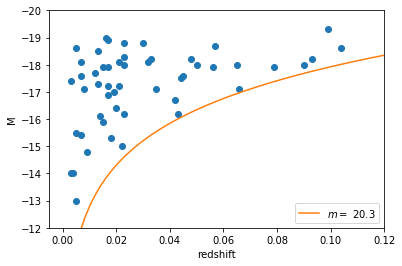

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

np.random.seed(4)

sn, host, refs = np.genfromtxt('jha2017-table1.csv', delimiter=',',skip_header=1,
                             dtype='unicode',unpack=True,usecols=(0,1,4))
z, M = np.genfromtxt('jha2017-table1.csv', delimiter=',',skip_header=1,
                             unpack=True,usecols=(2,3))

plt.plot(z,M,marker='o',linestyle="None")
plt.ylim(-12,-20)
plt.xlim(-0.005,0.12)
plt.xlabel('redshift')
plt.ylabel('M')

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
cosmo = FlatLambdaCDM(H0=73.0, Om0=0.3)
zz = np.linspace(0.001,0.15,100)
mu = 5.0 * np.log10(cosmo.luminosity_distance(zz)/u.Mpc) + 25.0

mlim = 20.3
plt.plot(zz,mlim-mu,label=r"$m =$ " + "{:.1f}".format(mlim))
plt.legend(loc="lower right")
plt.show()

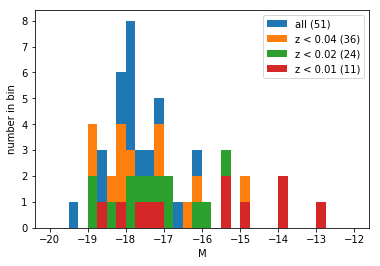

In [2]:
z1 = (z < 0.01)
z2 = (z < 0.02)
z4 = (z < 0.04)

n, b, p = plt.hist(M,label='all ({:d})'.format(len(M)),bins=32,range=[-20,-12])
plt.hist(M[z4],label='z < 0.04 ({:d})'.format(sum(z4)),bins=b)
plt.hist(M[z2],label='z < 0.02 ({:d})'.format(sum(z2)),bins=b)
plt.hist(M[z1],label='z < 0.01 ({:d})'.format(sum(z1)),bins=b)
plt.legend()
plt.xlabel('M')
plt.ylabel('number in bin')
plt.show()

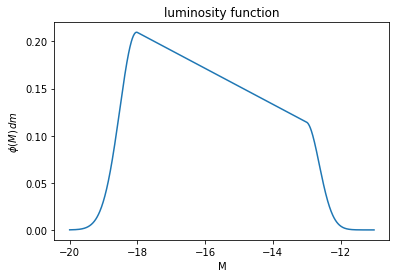

In [3]:
dx = 0.01
x = np.arange(-20,-11,dx)
nx = len(x)

# we approximate the luminosity function as linear, with
# Gaussian rolloffs at either end

# bright end rolloff
brightroll = -18.0
brightsig = 0.5

# faint end rolloff
faintroll = -13.0
faintsig = 0.4

# linear part
y = -(x+13.0)/6.0 + 1.0
#y = (x+19.0)/6.0 + 1.0
#y = np.ones(nx)

lx = (x < brightroll)
y[lx] *= np.exp(-(x[lx]-brightroll)**2/2.0/brightsig**2)
rx = (x > faintroll)
y[rx] *= np.exp(-(x[rx]-faintroll)**2/2.0/faintsig**2)
y /= np.sum(y)*dx

plt.plot(x,y)
plt.title('luminosity function')
plt.xlabel('M')
plt.ylabel(r'$\phi(M)\,dm$')
plt.show()

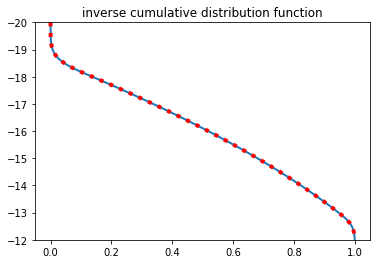

In [4]:
# to sample from this luminosity function 
# we calculate the cumulative distribution function
# and invert it via linear interpolation

cdf = np.cumsum(y)*dx
uy = np.arange(0,1,0.0001)
invcdf = np.interp(uy,cdf,x)

# plot it up and compare the interpolation
plt.plot(uy,invcdf,linewidth=2)
plt.plot(cdf,x,linestyle=':',linewidth=4,color='r')
plt.ylim(-12,-20)
plt.title('inverse cumulative distribution function')
plt.show()

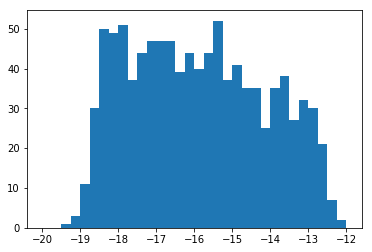

fraction brighter than -17.5:  0.231768231768


In [5]:
# once we have the invcdf we can just interpolate it
# with random uniform deviates to get our samples
ssize = 1001
unif = np.random.random(size=ssize)
Msamp = np.interp(unif,uy,invcdf)

plt.hist(Msamp,bins=32,range=[-20,-12])
plt.show()

print("fraction brighter than -17.5: ",sum(Msamp < -17.5)/len(Msamp))

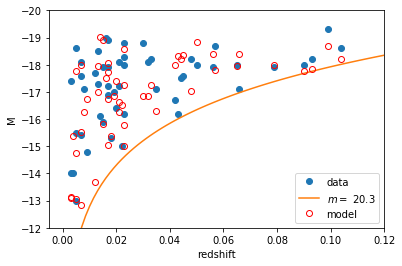

In [6]:
Mmodel = np.zeros(len(M))
muz = 5.0 * np.log10(cosmo.luminosity_distance(z)/u.Mpc) + 25.0

for i in range(len(M)):
    while True:
        iM = np.interp(np.random.random(),uy,invcdf)
        ms = iM + muz[i]
        if ms < mlim:
            break
    Mmodel[i] = iM
    
plt.plot(z,M,marker='o',linestyle="None",label='data')
plt.ylim(-12,-20)
plt.xlim(-0.005,0.12)
plt.xlabel('redshift')
plt.ylabel('M')
plt.plot(zz,mlim-mu,label=r"$m =$ " + "{:.1f}".format(mlim))
plt.plot(z,Mmodel,marker='o',linestyle="none", color='r',
        fillstyle="none",label='model')
plt.legend(loc="lower right")
plt.show()

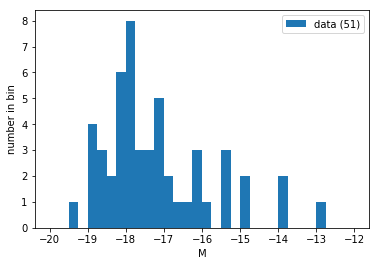

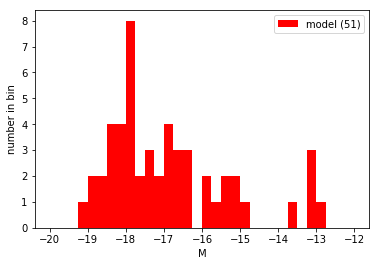

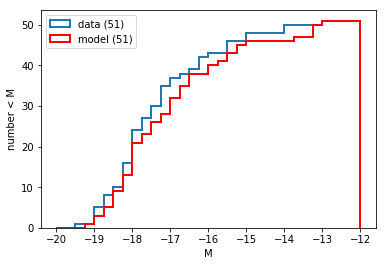

KS probability: 0.371
Anderson-Darling probability: 0.391


/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/morestats.py:1676: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


In [7]:
# do histogram version of the above
n, b, p = plt.hist(M,label='data ({:d})'.format(len(M)),bins=32,range=[-20,-12])
plt.legend()
plt.xlabel('M')
plt.ylabel('number in bin')
plt.show()

plt.hist(Mmodel,bins=b,label='model ({:d})'.format(len(Mmodel)),color='r')
plt.legend()
plt.xlabel('M')
plt.ylabel('number in bin')
plt.show()

plt.hist(M,bins=b,label='data ({:d})'.format(len(M)),
         cumulative=True,histtype='step',lw=2)
plt.hist(Mmodel,bins=b,label='model ({:d})'.format(len(Mmodel)),color='r',
         cumulative=True,histtype='step',lw=2)
plt.legend(loc='upper left')
plt.xlabel('M')
plt.ylabel('number < M')
plt.show()

from scipy.stats import ks_2samp, anderson_ksamp
ks, ksp = ks_2samp(M,Mmodel)
print("KS probability: {:.3f}".format(ksp))

ad, adcv, adp = anderson_ksamp([M,Mmodel])
print("Anderson-Darling probability: {:.3f}".format(adp))

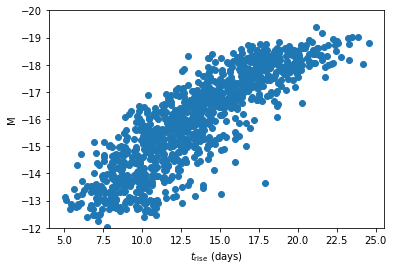

In [8]:
# given peak magnitude, estimate rise time from Magee et al. (2016, A&A, 589, A89)
# 3 mag = 10 days
trise = 21 - (Msamp + 19)*10/3.0 + 0.22*(Msamp + 19)**2 + np.random.normal(size=len(Msamp))*2.0

plt.scatter(trise,Msamp)
plt.xlabel(r'$t_{\rm rise}$ (days)')
plt.ylabel(r'M')
plt.ylim(-12,-20)
plt.show()

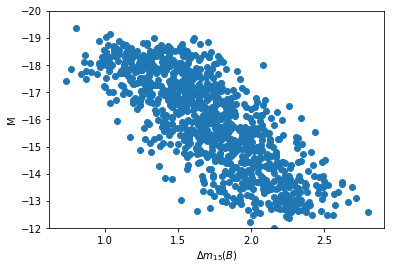

In [9]:
# estimate dm15(B)
dm15B = 1.2 + (Msamp + 19)/6.0 + np.random.normal(size=len(Msamp))*0.25

plt.scatter(dm15B,Msamp)
plt.ylim(-12,-20)
plt.xlabel(r'$\Delta m_{15}(B)$')
plt.ylabel(r'M')
plt.show()

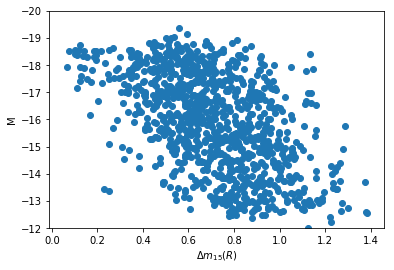

In [10]:
# estimate dm15(R)
dm15R = np.abs(0.5 + (Msamp + 19)/15.0 + np.random.normal(size=len(Msamp))*0.2)

plt.scatter(dm15R,Msamp)
plt.ylim(-12,-20)
plt.xlabel(r'$\Delta m_{15}(R)$')
plt.ylabel(r'M')
plt.show()

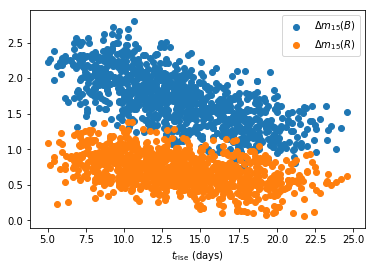

In [11]:
plt.scatter(trise,dm15B,label=r'$\Delta m_{15}(B)$')
plt.scatter(trise,dm15R,label=r'$\Delta m_{15}(R)$')
plt.xlabel(r'$t_{\rm rise}$ (days)')
plt.legend()
plt.show()

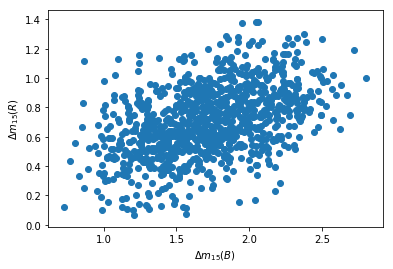

In [12]:
plt.scatter(dm15B,dm15R)
plt.xlabel(r'$\Delta m_{15}(B)$')
plt.ylabel(r'$\Delta m_{15}(R)$')
plt.show()

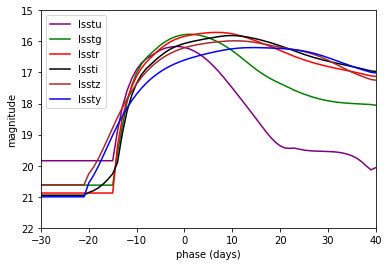

input Vmag: 15.7692644017
input trise: 15.0
input dm15B: 1.61714453848
input dm15R: 0.118086743555


In [39]:
import pickle
import sncosmo
import scipy

# import SN2005hk SED
source = pickle.load(open('SN2005hk/sn2005hk.source.pickle', "rb" ), encoding="latin-1" )['source']
origmodel = sncosmo.Model(source=source)

phase = np.linspace(-30.,200.,231)
nphase = len(phase)
wave = np.linspace(1000.,25000.,2401)
nwave = len(wave)

origflux = origmodel.flux(phase,wave)
flux = np.copy(origflux)

# smooth z and y bands which are too wiggly
zy = np.where( (wave >= 8000.) & (wave <= 11000.))
flux[10:,zy] = scipy.ndimage.gaussian_filter(origflux,[4.0,0.0])[10:,zy]

# extend to late times and smooth it
#   enforce 0.015 mag/day (= 72.4 d e-folding) late-time decline rate
late = np.where(phase >= 50.)
flux[late,:] *= np.exp(-(phase[late,None]-50.)/72.4)
flux[70:,:] = scipy.ndimage.gaussian_filter(flux,[4.0,0.0])[70:,:]    

filters = ['lsstu','lsstg','lsstr','lssti','lsstz','lssty']
colors = ['purple','green','red','black','brown','blue']
sedmodel = sncosmo.Model(source=sncosmo.TimeSeriesSource(phase,wave,flux))

plt.plot()
for f,c in zip(filters,colors):
    band = sncosmo.get_bandpass(f)
    sedmag = sedmodel.bandmag(band,'ab',phase)
    plt.plot(phase,sedmag,label=f,color=c)
plt.xlim(-30,40)
plt.ylim(22,15)
plt.xlabel('phase (days)')
plt.ylabel('magnitude')
plt.legend()
plt.show()

sedVmag = sedmodel.bandmag('bessellv','vega',0.0)
print("input Vmag:",sedVmag)
sedtrise = 15.0   # hardcoded in the SED
print("input trise:",sedtrise)
seddm15B = sedmodel.bandmag('bessellb','vega',15.0) - sedmodel.bandmag('bessellb','vega',0.0)
print("input dm15B:",seddm15B)
seddm15R = sedmodel.bandmag('bessellr','vega',15.0) - sedmodel.bandmag('bessellr','vega',0.0)
print("input dm15R:",seddm15R)

# make model 0 match the input exactly
Msamp[0] = sedVmag - 33.46
trise[0] = sedtrise
dm15B[0] = seddm15B
dm15R[0] = seddm15R

In [58]:
amplitudes = 10.0**(-0.4*(Msamp - sedVmag))

filedir = 'outSED/'
inoutfile = 'inout.dat'
sedfilename = 'SED.INFO'

with open(filedir+sedfilename,'w') as sf:
    print("# Iax spectra translated into SNANA-SIMSED format", file=sf)
    print("#    based on SN 2005hk by Saurabh Jha and Mi Dai",file=sf)
    print(" ",file=sf)
    print("FLUX_SCALE:  1.0",file=sf)
    print("MAG_ERR:     0.100",file=sf)
    print("RESTLAMBDA_RANGE:  1000  25000",file=sf)
    print("FLUX_ERRFLAG: 0",file=sf)
    print("NPAR: 5",file=sf)
    print(" ",file=sf)
    print("PARNAMES: Iax_INDEX  M_V  t_rise  dm15B  dm15R",file=sf)

with open(filedir+inoutfile,'w') as iof:
    print("#    i    M                trise        dm15B        dm15R",file=iof)
    
print("    i    M                trise        dm15B        dm15R")
for ref in range(10):

    filename = 'SED-Iax-{:04d}'.format(ref)
    
    # set model amplitude to match M_V
    sedmodel.set(amplitude=amplitudes[ref])
    flux = sedmodel.flux(phase,wave)

    # stretch pre-max SED to give correct trise
    premax = np.where(phase < 0.)
    newphase = np.copy(phase)
    newphase[premax] *= trise[ref]/sedtrise
    preexp = np.where(newphase < -trise[ref])
    flux[preexp] /= 2000.0
    newmodel = sncosmo.TimeSeriesSource(newphase,wave,flux)

    # warp SED to match dm15B
    seddm15B = newmodel.bandmag('bessellb','vega',15.0) - newmodel.bandmag('bessellb','vega',0.0)
    flux = newmodel.flux(newphase,wave)
    sc = 10.0**(-0.4*(dm15B[ref] - seddm15B))
    mult = np.ones_like(newphase)
    postmax = np.where(newphase > 1.0)
    mult[postmax] = 1.0 + (sc - 1.0)*np.exp(-((np.log10(newphase[postmax]) 
                                               - np.log10(15.0))**2/2.0/0.2**2))
    scflux = flux * mult[:,None]
    scmodel = sncosmo.TimeSeriesSource(newphase,wave,scflux)

    # warp SED to match dm15R (keeping dm15B)
    scdm15B = scmodel.bandmag('bessellb','vega',15.0) - scmodel.bandmag('bessellb','vega',0.0)
    scdm15R = scmodel.bandmag('bessellr','vega',15.0) - scmodel.bandmag('bessellr','vega',0.0)
    scR = 10.0**(-0.4*(dm15R[ref] - scdm15R))
    multB = np.ones_like(newphase)
    multR = np.ones_like(newphase)
    postmax = np.where(newphase > 1.0)
    multR[postmax] = 1.0 + (scR - 1.0)*1.095*np.exp(-((np.log10(newphase[postmax]) 
                                               - np.log10(15.0))**2/2.0/0.2**2))
    wx = np.array([2350., 5200., 6000., 7500., 9000.])
    mm = np.array([multB, multB, multR, multR, multB])
    f = interpolate.interp2d(newphase,wx,mm)
    nmult = np.transpose(f(newphase,wave))

    outflux = scflux * nmult
    outmodel = sncosmo.TimeSeriesSource(newphase,wave,outflux)
    outdm15B = outmodel.bandmag('bessellb','vega',15.0) - outmodel.bandmag('bessellb','vega',0.0)
    outdm15R = outmodel.bandmag('bessellr','vega',15.0) - outmodel.bandmag('bessellr','vega',0.0)

    plt.plot()
    for f,c in zip(filters, colors):
        band = sncosmo.get_bandpass(f)
        plt.plot(phase,outmodel.bandmag(band,'ab',phase),label=f,color=c)
        plt.plot(phase,sedmodel.bandmag(band,'ab',phase),'--',color=c)
    plt.xlim(-trise[ref]-5,-trise[ref]+80)
    plt.ylim(Msamp[ref]+4.0,Msamp[ref]-0.5)
    plt.xlabel('phase (days)')
    plt.ylabel('magnitude')
    plt.legend()
    plt.savefig(filedir+filename+'.pdf')
    plt.close()
#    plt.show()

    print(" in",ref,Msamp[ref],trise[ref],dm15B[ref],dm15R[ref])
    outMV = outmodel.bandmag('bessellv','vega',0.0)
    pret = np.arange(-30.0,0.0,0.01)
    dV = outmodel.bandmag('bessellv','vega',pret) - outMV
    outt = -np.min(pret[dV < 5.0])
    print("out",ref,outMV,outt,outdm15B,outdm15R)

    with open(filedir+inoutfile,'a') as iof:
        print(filename,Msamp[ref],outMV,trise[ref],outt,dm15B[ref],outdm15B,dm15R[ref],outdm15R,
              file=iof)
    
    outphase = np.concatenate((np.arange(-25.0,40.5,1.0),
                               np.arange(42.0,70.5,2.0), 
                               np.arange(75.0,100.5,5.0),
                               np.arange(110.0,140.5,10.0),
                               np.arange(160.0,200.5,20.0)))

    with open(filedir+filename+'.dat','wb') as f:
        for p in outphase:
            parr = np.array([p]*nwave)
            flux = np.clip(outmodel.flux(p,wave),1.0e-99,None)
            stack = np.concatenate(([parr],[wave],[flux]),axis=0)
            np.savetxt(f,stack.T,fmt="%+4.1f %8.1f %15.6e")
            
    with open(filedir+sedfilename,'a') as sf:
        print("SED: {:15s}    {:04d} {:10.3f} {:10.3f} {:10.3f} {:10.3f}".format(filename+'.dat', 
            ref,Msamp[ref],trise[ref],dm15B[ref],dm15R[ref]),file=sf)

    i    M                trise        dm15B        dm15R
 in 0 -17.6907355983 15.0 1.61714453848 0.118086743555
out 0 -17.6907355983 15.03 1.61714453848 0.118086743555


/usr/local/anaconda/lib/python3.6/site-packages/sncosmo/models.py:187: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in less


 in 1 -15.8274860252 14.3271472069 1.74331041642 0.903555226423
out 1 -15.8274860252 14.36 1.74642254927 0.903996750742
 in 2 -12.747604102 8.63171439238 2.37500470409 0.791852431792
out 2 -12.747604102 8.65 2.37445498052 0.791813047951
 in 3 -14.7666419827 7.08239835257 1.7863431398 1.05741316563
out 3 -14.7666419827 7.09 1.78981736361 1.05795896478
 in 4 -14.8813526568 10.8090059341 1.62788919238 0.916286638052
out 4 -14.8813526568 10.83 1.63141677199 0.916849725235
 in 5 -17.6163181481 18.1048539309 1.15466512177 0.370066533489
out 5 -17.6163181481 18.14 1.15796206784 0.370558623051
 in 6 -12.7056281776 7.92474905603 2.30626966878 1.0967359152
out 6 -12.7056281776 7.94 2.30786902434 1.09689741669
 in 7 -19.017609569 23.8751103671 1.00573275527 0.537449869584
out 7 -19.017609569 23.93 1.00992644074 0.538287291379
 in 8 -17.4322247201 18.9569466434 1.52578179803 0.836696234154
out 8 -17.4322247201 19.0 1.52937745719 0.837282203773
 in 9 -16.4728634207 12.9256554964 2.0262374385 0.9548